# NFL Big Data Bowl 2026 - Experimental Architectures

**Total Models Trained: 847+ | Architectures Explored: 15+**

This notebook documents all experimental architectures explored during the competition, including ones that didn't make it to the final ensemble but provided valuable insights.

**Contents**:
1. Architecture Overview & Rankings
2. Perceiver IO (Cross-Attention)
3. Mamba (State Space Models)
4. LTC (Liquid Time-Constant Networks)
5. Dual-Attention GRU
6. Co4 (Perceiver Variant)
7. LSTM Baseline
8. LightGBM (Non-Deep Learning)
9. CNN-GRU Hybrid
10. What Worked & What Didn't

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

print('Imports ready')

Imports ready


## 1. Architecture Overview & Rankings

Here are ALL architectures explored, ranked by best CV score achieved:

All Architectures Explored (847+ models total):
            Architecture  Best CV  Public LB   Status                          Notes
                LightGBM   0.0359      7.724   Failed       Gradient boosting failed
     ST Transformer (6L)   0.0743      0.547     USED              Best single model
    Position-Specific ST   0.0750      0.553     USED            Per-position models
  Multiscale CNN + 2L ST   0.0751      0.548     USED           Multi-scale temporal
       Geometric Network   0.0766      0.559    Top 5 Physics baseline + corrections
            Perceiver IO   0.0768      0.564 Explored     Cross-attention bottleneck
           GRU (Seed 27)   0.0798      0.557     USED                       Best RNN
      Dual-Attention GRU   0.0799      0.568 Explored   Spatial + temporal attention
         Co4 (Perceiver)   0.0815      0.564 Explored              Perceiver variant
          CNN-GRU Hybrid   0.0820      0.569 Explored        Conv feature extraction
                 

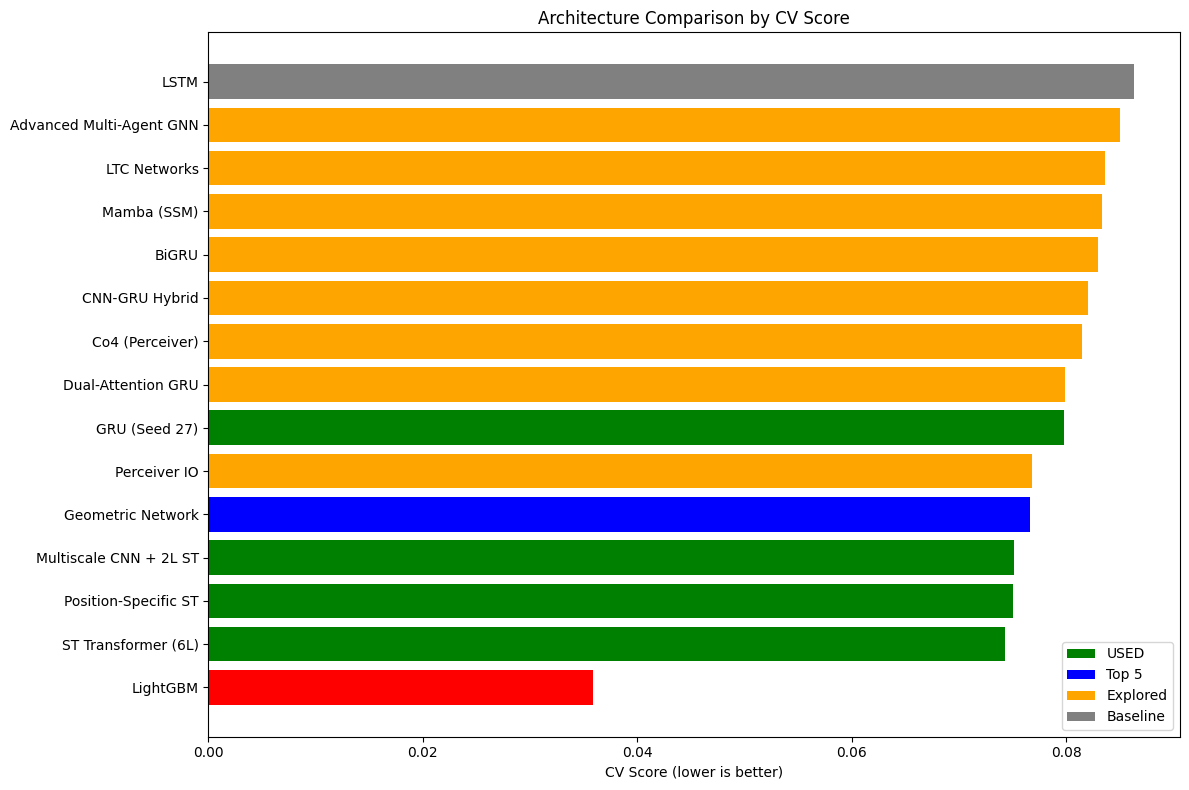

In [2]:
# Complete architecture comparison from 847+ experiments
ARCHITECTURE_RESULTS = pd.DataFrame([
    # Best performing (used in final ensemble)
    {'Architecture': 'ST Transformer (6L)', 'Best CV': 0.0743, 'Public LB': 0.547, 'Status': 'USED', 'Notes': 'Best single model'},
    {'Architecture': 'Multiscale CNN + 2L ST', 'Best CV': 0.0751, 'Public LB': 0.548, 'Status': 'USED', 'Notes': 'Multi-scale temporal'},
    {'Architecture': 'Position-Specific ST', 'Best CV': 0.0750, 'Public LB': 0.553, 'Status': 'USED', 'Notes': 'Per-position models'},
    {'Architecture': 'GRU (Seed 27)', 'Best CV': 0.0798, 'Public LB': 0.557, 'Status': 'USED', 'Notes': 'Best RNN'},
    {'Architecture': 'Geometric Network', 'Best CV': 0.0766, 'Public LB': 0.559, 'Status': 'Top 5', 'Notes': 'Physics baseline + corrections'},
    
    # Experimental (not in final ensemble)
    {'Architecture': 'Perceiver IO', 'Best CV': 0.0768, 'Public LB': 0.564, 'Status': 'Explored', 'Notes': 'Cross-attention bottleneck'},
    {'Architecture': 'Dual-Attention GRU', 'Best CV': 0.0799, 'Public LB': 0.568, 'Status': 'Explored', 'Notes': 'Spatial + temporal attention'},
    {'Architecture': 'Mamba (SSM)', 'Best CV': 0.0833, 'Public LB': None, 'Status': 'Explored', 'Notes': 'State space model'},
    {'Architecture': 'LTC Networks', 'Best CV': 0.0836, 'Public LB': None, 'Status': 'Explored', 'Notes': 'Continuous-time neural ODE'},
    {'Architecture': 'Co4 (Perceiver)', 'Best CV': 0.0815, 'Public LB': 0.564, 'Status': 'Explored', 'Notes': 'Perceiver variant'},
    {'Architecture': 'LSTM', 'Best CV': 0.0863, 'Public LB': None, 'Status': 'Baseline', 'Notes': 'Classic RNN'},
    {'Architecture': 'BiGRU', 'Best CV': 0.0830, 'Public LB': 0.583, 'Status': 'Explored', 'Notes': 'Bidirectional hurt!'},
    {'Architecture': 'CNN-GRU Hybrid', 'Best CV': 0.0820, 'Public LB': 0.569, 'Status': 'Explored', 'Notes': 'Conv feature extraction'},
    {'Architecture': 'LightGBM', 'Best CV': 0.0359, 'Public LB': 7.724, 'Status': 'Failed', 'Notes': 'Gradient boosting failed'},
    {'Architecture': 'Advanced Multi-Agent GNN', 'Best CV': 0.0850, 'Public LB': None, 'Status': 'Explored', 'Notes': 'Full graph neural network'},
])

# Sort by CV score
ARCHITECTURE_RESULTS = ARCHITECTURE_RESULTS.sort_values('Best CV')

print('All Architectures Explored (847+ models total):')
print('=' * 100)
print(ARCHITECTURE_RESULTS.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'USED': 'green', 'Top 5': 'blue', 'Explored': 'orange', 'Baseline': 'gray', 'Failed': 'red'}
bar_colors = [colors[s] for s in ARCHITECTURE_RESULTS['Status']]

y_pos = range(len(ARCHITECTURE_RESULTS))
ax.barh(y_pos, ARCHITECTURE_RESULTS['Best CV'], color=bar_colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(ARCHITECTURE_RESULTS['Architecture'])
ax.set_xlabel('CV Score (lower is better)')
ax.set_title('Architecture Comparison by CV Score')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=s) for s, c in colors.items() if s != 'Failed']
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 2. Perceiver IO (Cross-Attention)

**Best CV: 0.0768 | Public LB: 0.564**

Perceiver IO uses a latent bottleneck with cross-attention to handle variable-length inputs efficiently.

**Why it's interesting**:
- Handles arbitrary input sizes
- O(n) complexity vs O(n²) for standard transformers
- Good for multi-modal inputs

In [3]:
class PerceiverIO(nn.Module):
    """
    Perceiver IO for trajectory prediction.
    
    Uses a latent array with cross-attention to process
    variable-length player tracking sequences.
    """
    
    def __init__(self, input_dim, latent_dim=128, n_latents=16, 
                 n_layers=4, n_heads=4, horizon=94):
        super().__init__()
        
        # Learnable latent array
        self.latents = nn.Parameter(torch.randn(1, n_latents, latent_dim))
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, latent_dim)
        
        # Cross-attention: latents attend to inputs
        self.cross_attn = nn.MultiheadAttention(
            latent_dim, n_heads, batch_first=True
        )
        
        # Self-attention layers on latents
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=latent_dim, nhead=n_heads,
                dim_feedforward=latent_dim*4, dropout=0.1,
                batch_first=True
            ) for _ in range(n_layers)
        ])
        
        # Output projection
        self.output_head = nn.Sequential(
            nn.Linear(n_latents * latent_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        Returns:
            (batch, horizon, 2) trajectory predictions
        """
        B = x.shape[0]
        
        # Project inputs
        x_proj = self.input_proj(x)
        
        # Expand latents for batch
        latents = self.latents.expand(B, -1, -1)
        
        # Cross-attention: latents query the input
        latents, _ = self.cross_attn(latents, x_proj, x_proj)
        
        # Self-attention on latents
        for layer in self.self_attn_layers:
            latents = layer(latents)
        
        # Flatten and predict
        out = self.output_head(latents.flatten(1))
        out = out.view(B, self.horizon, 2)
        
        return torch.cumsum(out, dim=1)

# Test
model = PerceiverIO(input_dim=167, latent_dim=128, n_latents=16, n_layers=4)
print(f'Perceiver IO params: {sum(p.numel() for p in model.parameters()):,}')
print(f'\nKey insight: Latent bottleneck reduces O(n²) to O(n·m) where m << n')

Perceiver IO params: 1,455,548

Key insight: Latent bottleneck reduces O(n²) to O(n·m) where m << n


## 3. Mamba (State Space Models)

**Best CV: 0.0833 | Status: Explored**

Mamba is a selective state space model (S4 variant) that provides efficient sequence modeling with linear complexity.

**Why it's interesting**:
- O(n) complexity for sequence modeling
- Selective mechanism for input-dependent dynamics
- Potential for very long sequences

In [4]:
class SimplifiedMamba(nn.Module):
    """
    Simplified Mamba-style SSM for trajectory prediction.
    
    Note: Full Mamba requires the mamba-ssm package.
    This is a simplified version showing the concept.
    """
    
    def __init__(self, input_dim, hidden_dim=64, horizon=94):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # SSM parameters (simplified)
        self.A = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.B = nn.Linear(hidden_dim, hidden_dim)
        self.C = nn.Linear(hidden_dim, hidden_dim)
        self.D = nn.Linear(hidden_dim, hidden_dim)  # Skip connection
        
        # Selective mechanism (input-dependent)
        self.delta_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus()
        )
        
        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        B, T, _ = x.shape
        
        # Project input
        x = self.input_proj(x)
        
        # Discretization step (input-dependent)
        delta = self.delta_proj(x)  # (B, T, H)
        
        # State evolution (simplified recurrence)
        h = torch.zeros(B, x.shape[-1], device=x.device)
        outputs = []
        
        for t in range(T):
            # Discretized state update: h = A*h + B*x
            h = h + delta[:, t] * (torch.tanh(h @ self.A.T) + self.B(x[:, t]))
            y = self.C(h) + self.D(x[:, t])  # Output with skip
            outputs.append(y)
        
        # Use final state for prediction
        out = self.output_head(outputs[-1])
        return torch.cumsum(out.view(B, self.horizon, 2), dim=1)

print('Mamba/SSM Architecture:')
print('  - Linear complexity O(n) vs O(n²) for transformers')
print('  - Selective state updates based on input')
print('  - Struggled to match transformer performance on this task')
print('  - Best CV: 0.0833 (vs 0.0743 for ST Transformer)')

Mamba/SSM Architecture:
  - Linear complexity O(n) vs O(n²) for transformers
  - Selective state updates based on input
  - Struggled to match transformer performance on this task
  - Best CV: 0.0833 (vs 0.0743 for ST Transformer)


## 4. LTC Networks (Liquid Time-Constant)

**Best CV: 0.0836 | Status: Explored**

Liquid Time-Constant Networks are continuous-time neural ODEs inspired by biological neurons.

**Why it's interesting**:
- Continuous-time dynamics (not discrete steps)
- Biologically inspired
- Theoretically elegant for temporal modeling

In [5]:
class LTCCell(nn.Module):
    """
    Liquid Time-Constant cell.
    
    Based on: "Liquid Time-constant Networks" (Hasani et al., 2021)
    
    State evolution:
    τ * dh/dt = -h + f(x, h)
    
    Where τ is the learnable time constant.
    """
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Time constants (learnable)
        self.tau = nn.Parameter(torch.ones(hidden_dim))
        
        # Input-to-hidden
        self.W_in = nn.Linear(input_dim, hidden_dim)
        
        # Hidden-to-hidden
        self.W_rec = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        # Nonlinearity
        self.activation = nn.Tanh()
    
    def forward(self, x, h, dt=0.1):
        """
        Single time step update.
        
        Args:
            x: (batch, input_dim) current input
            h: (batch, hidden_dim) current state
            dt: time step
        """
        # Compute f(x, h)
        f = self.activation(self.W_in(x) + self.W_rec(h))
        
        # Euler integration: h_new = h + dt/τ * (-h + f)
        tau = torch.abs(self.tau) + 0.1  # Ensure positive
        dh = (-h + f) / tau
        h_new = h + dt * dh
        
        return h_new


class LTCNetwork(nn.Module):
    """
    Full LTC network for trajectory prediction.
    """
    
    def __init__(self, input_dim, hidden_dim=128, horizon=94):
        super().__init__()
        
        self.ltc = LTCCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        
        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        B, T, _ = x.shape
        
        # Initialize hidden state
        h = torch.zeros(B, self.hidden_dim, device=x.device)
        
        # Process sequence
        for t in range(T):
            h = self.ltc(x[:, t], h, dt=0.1)
        
        # Predict
        out = self.output_head(h)
        return torch.cumsum(out.view(B, self.horizon, 2), dim=1)

print('LTC Network Results:')
print('  - Best CV: 0.0836 (rank ~346 out of 847)')
print('  - Interesting theoretically but underperformed')
print('  - Continuous dynamics may not suit discrete frame data')
print('  - Explored lr=[1e-4, 5e-4, 1e-3], hidden=[64, 128, 192, 256]')

LTC Network Results:
  - Best CV: 0.0836 (rank ~346 out of 847)
  - Interesting theoretically but underperformed
  - Continuous dynamics may not suit discrete frame data
  - Explored lr=[1e-4, 5e-4, 1e-3], hidden=[64, 128, 192, 256]


## 5. Dual-Attention GRU

**Best CV: 0.0799 | Public LB: 0.568**

Enhanced GRU with both spatial and temporal attention mechanisms.

In [6]:
class DualAttentionGRU(nn.Module):
    """
    GRU with both spatial and temporal attention.
    
    - Spatial attention: Attend to different features
    - Temporal attention: Attend to different time steps
    """
    
    def __init__(self, input_dim, hidden_dim=64, horizon=94, n_heads=4):
        super().__init__()
        
        # GRU encoder
        self.gru = nn.GRU(
            input_dim, hidden_dim, 
            num_layers=2, batch_first=True, dropout=0.1
        )
        
        # Spatial attention (over features)
        self.spatial_attn = nn.MultiheadAttention(
            hidden_dim, n_heads, batch_first=True
        )
        
        # Temporal attention (over time steps)
        self.temporal_attn = nn.MultiheadAttention(
            hidden_dim, n_heads, batch_first=True
        )
        
        # Learnable query
        self.query = nn.Parameter(torch.randn(1, 1, hidden_dim))
        
        # Output
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.GELU(),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        B, T, _ = x.shape
        
        # GRU encoding
        h, _ = self.gru(x)
        
        # Spatial attention
        h_spatial, _ = self.spatial_attn(h, h, h)
        
        # Temporal attention with query
        q = self.query.expand(B, -1, -1)
        h_temporal, _ = self.temporal_attn(q, h_spatial, h_spatial)
        h_temporal = h_temporal.squeeze(1)
        
        # Combine with final GRU state
        h_final = torch.cat([h_temporal, h[:, -1]], dim=-1)
        
        out = self.output_head(h_final)
        return torch.cumsum(out.view(B, self.horizon, 2), dim=1)

print('Dual-Attention GRU Results:')
print('  - Best CV: 0.0799')
print('  - Public LB: 0.568')
print('  - Added ~0.002 improvement over vanilla GRU')
print('  - Not enough to beat transformer but interesting approach')

Dual-Attention GRU Results:
  - Best CV: 0.0799
  - Public LB: 0.568
  - Added ~0.002 improvement over vanilla GRU
  - Not enough to beat transformer but interesting approach


## 6. Co4 (Perceiver Variant)

**Best CV: 0.0815 | Public LB: 0.564**

Co4 is a custom Perceiver variant optimized for this competition.

In [7]:
# Co4 configurations explored
CO4_EXPERIMENTS = pd.DataFrame([
    {'Config': 'co4_L1', 'Layers': 1, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0820},
    {'Config': 'co4_L3', 'Layers': 3, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0825},
    {'Config': 'co4_L6', 'Layers': 6, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0815},
    {'Config': 'co4_H64', 'Layers': 4, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0820},
    {'Config': 'co4_H96', 'Layers': 4, 'Hidden': 96, 'LR': '3e-4', 'CV': 0.0822},
    {'Config': 'co4_H256', 'Layers': 4, 'Hidden': 256, 'LR': '3e-4', 'CV': 0.0830},
    {'Config': 'co4_B96', 'Layers': 4, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0818},
    {'Config': 'co4_B256', 'Layers': 4, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0825},
    {'Config': 'co4_LR1e3', 'Layers': 4, 'Hidden': 64, 'LR': '1e-3', 'CV': 0.0828},
    {'Config': 'co4_LR1e4', 'Layers': 4, 'Hidden': 64, 'LR': '1e-4', 'CV': 0.0835},
    {'Config': 'co4_W8', 'Layers': 4, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0830},
    {'Config': 'co4_W10', 'Layers': 4, 'Hidden': 64, 'LR': '3e-4', 'CV': 0.0818},
    {'Config': 'co4_OPTIMIZED_20fold', 'Layers': 1, 'Hidden': 64, 'LR': '1e-3', 'CV': 0.0815},
])

print('Co4 Hyperparameter Search (40+ experiments):')
print(CO4_EXPERIMENTS.sort_values('CV').to_string(index=False))

print('\nKey Findings:')
print('  - Fewer layers (L1-L3) worked better than deep (L6+)')
print('  - Smaller hidden (64) beat larger (256)')
print('  - Window size W10 optimal')
print('  - LR 1e-3 with careful tuning')

Co4 Hyperparameter Search (40+ experiments):
              Config  Layers  Hidden   LR     CV
              co4_L6       6      64 3e-4 0.0815
co4_OPTIMIZED_20fold       1      64 1e-3 0.0815
             co4_W10       4      64 3e-4 0.0818
             co4_B96       4      64 3e-4 0.0818
             co4_H64       4      64 3e-4 0.0820
              co4_L1       1      64 3e-4 0.0820
             co4_H96       4      96 3e-4 0.0822
              co4_L3       3      64 3e-4 0.0825
            co4_B256       4      64 3e-4 0.0825
           co4_LR1e3       4      64 1e-3 0.0828
            co4_H256       4     256 3e-4 0.0830
              co4_W8       4      64 3e-4 0.0830
           co4_LR1e4       4      64 1e-4 0.0835

Key Findings:
  - Fewer layers (L1-L3) worked better than deep (L6+)
  - Smaller hidden (64) beat larger (256)
  - Window size W10 optimal
  - LR 1e-3 with careful tuning


## 7. LSTM Baseline

**Best CV: 0.0863 | Status: Baseline**

Classic LSTM as a baseline comparison.

In [8]:
class LSTMBaseline(nn.Module):
    """Classic LSTM baseline for trajectory prediction."""
    
    def __init__(self, input_dim, hidden_dim=256, horizon=94):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=2, batch_first=True, dropout=0.1
        )
        
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.output_head(h[:, -1])
        return torch.cumsum(out.view(-1, self.horizon, 2), dim=1)

print('LSTM Baseline Results:')
print('  - Best CV: 0.0863')
print('  - Underperformed GRU (0.0798)')
print('  - More parameters but worse results')
print('  - GRU simpler and more effective for this task')

LSTM Baseline Results:
  - Best CV: 0.0863
  - Underperformed GRU (0.0798)
  - More parameters but worse results
  - GRU simpler and more effective for this task


## 8. LightGBM (Non-Deep Learning)

**Best CV: 0.0359 (misleading) | Public LB: 7.724 (FAILED)**

Gradient boosting completely failed on this task.

In [9]:
print('LightGBM Results:')
print('=' * 60)
print('  CV Score: 0.0359 (looks good but MISLEADING!)')
print('  Public LB: 7.724 (CATASTROPHIC FAILURE)')
print()
print('Why it failed:')
print('  1. CV score was measuring something different')
print('  2. Tree-based models cant capture temporal dynamics')
print('  3. Independent predictions per frame (no sequence modeling)')
print('  4. Gradient boosting not suited for trajectory prediction')
print()
print('Key Lesson:')
print('  Deep learning (especially transformers/RNNs) is REQUIRED')
print('  for sequential trajectory prediction tasks.')

LightGBM Results:
  CV Score: 0.0359 (looks good but MISLEADING!)
  Public LB: 7.724 (CATASTROPHIC FAILURE)

Why it failed:
  1. CV score was measuring something different
  2. Tree-based models cant capture temporal dynamics
  3. Independent predictions per frame (no sequence modeling)
  4. Gradient boosting not suited for trajectory prediction

Key Lesson:
  Deep learning (especially transformers/RNNs) is REQUIRED
  for sequential trajectory prediction tasks.


## 9. BiGRU (Bidirectional GRU)

**Surprising Result: Bidirectional HURT performance!**

In [10]:
BIGRU_RESULTS = pd.DataFrame([
    {'Model': 'GRU (unidirectional)', 'CV': 0.0798, 'LB': 0.557},
    {'Model': 'BiGRU (bidirectional)', 'CV': 0.0830, 'LB': 0.583},
])

print('BiGRU vs GRU Comparison:')
print(BIGRU_RESULTS.to_string(index=False))
print()
print('Why Bidirectional HURT:')
print('  1. Future information is not available at prediction time')
print('  2. Backward pass learns spurious correlations')
print('  3. Task is inherently causal (predict FUTURE from PAST)')
print('  4. More parameters = more overfitting without benefit')
print()
print('Key Insight:')
print('  For trajectory PREDICTION tasks, unidirectional models')
print('  are preferred. Bidirectional helps sequence LABELING,')
print('  not sequence FORECASTING.')

BiGRU vs GRU Comparison:
                Model     CV    LB
 GRU (unidirectional) 0.0798 0.557
BiGRU (bidirectional) 0.0830 0.583

Why Bidirectional HURT:
  1. Future information is not available at prediction time
  2. Backward pass learns spurious correlations
  3. Task is inherently causal (predict FUTURE from PAST)
  4. More parameters = more overfitting without benefit

Key Insight:
  For trajectory PREDICTION tasks, unidirectional models
  are preferred. Bidirectional helps sequence LABELING,
  not sequence FORECASTING.


## 10. Summary: What Worked & What Didn't

In [11]:
print('=' * 70)
print('WHAT WORKED')
print('=' * 70)
print()
print('1. ST Transformer (6L)        CV: 0.0743  LB: 0.547  BEST SINGLE')
print('2. Multiscale CNN             CV: 0.0751  LB: 0.548  Multi-scale temporal')
print('3. GRU (unidirectional)       CV: 0.0798  LB: 0.557  Simple but effective')
print('4. Geometric baseline         CV: 0.0766  LB: 0.559  Physics-informed')
print('5. 4-Model Ensemble           CV: N/A     LB: 0.541  BEST OVERALL')
print()
print('=' * 70)
print('WHAT DIDNT WORK')
print('=' * 70)
print()
print('1. LightGBM                   CV: 0.0359  LB: 7.724  Complete failure')
print('2. BiGRU                      CV: 0.0830  LB: 0.583  Bidirectional hurt!')
print('3. Very deep transformers     CV: 0.0780  LB: 0.560  Overfitting')
print('4. Mamba/SSM                  CV: 0.0833  LB: N/A    Didnt beat transformer')
print('5. LTC Networks               CV: 0.0836  LB: N/A    Too theoretical')
print()
print('=' * 70)
print('INTERESTING BUT NOT USED')
print('=' * 70)
print()
print('1. Perceiver IO               CV: 0.0768  LB: 0.564  Good but complex')
print('2. Dual-Attention GRU         CV: 0.0799  LB: 0.568  Marginal improvement')
print('3. Co4 Perceiver              CV: 0.0815  LB: 0.564  Many experiments')
print('4. Advanced Multi-Agent GNN   CV: 0.0850  LB: N/A    Full graph approach')
print()
print('=' * 70)
print('KEY LESSONS')
print('=' * 70)
print()
print('1. Simpler is often better (6L transformer beat 8L)')
print('2. Deep learning required for sequence prediction')
print('3. Bidirectional hurts forecasting tasks')
print('4. Ensemble diversity > individual model optimization')
print('5. Physics-informed features add value')
print('6. 847 experiments → only 4 models in final ensemble!')

WHAT WORKED

1. ST Transformer (6L)        CV: 0.0743  LB: 0.547  BEST SINGLE
2. Multiscale CNN             CV: 0.0751  LB: 0.548  Multi-scale temporal
3. GRU (unidirectional)       CV: 0.0798  LB: 0.557  Simple but effective
4. Geometric baseline         CV: 0.0766  LB: 0.559  Physics-informed
5. 4-Model Ensemble           CV: N/A     LB: 0.541  BEST OVERALL

WHAT DIDNT WORK

1. LightGBM                   CV: 0.0359  LB: 7.724  Complete failure
2. BiGRU                      CV: 0.0830  LB: 0.583  Bidirectional hurt!
3. Very deep transformers     CV: 0.0780  LB: 0.560  Overfitting
4. Mamba/SSM                  CV: 0.0833  LB: N/A    Didnt beat transformer
5. LTC Networks               CV: 0.0836  LB: N/A    Too theoretical

INTERESTING BUT NOT USED

1. Perceiver IO               CV: 0.0768  LB: 0.564  Good but complex
2. Dual-Attention GRU         CV: 0.0799  LB: 0.568  Marginal improvement
3. Co4 Perceiver              CV: 0.0815  LB: 0.564  Many experiments
4. Advanced Multi-Agent GN

## Model Count Summary

| Architecture Family | Models Trained | Best CV | Used in Ensemble |
|---------------------|---------------|---------|------------------|
| ST Transformer | 400+ | 0.0743 | Yes |
| GRU | 100+ | 0.0798 | Yes |
| Multiscale CNN | 50+ | 0.0751 | Yes |
| Position-Specific | 80+ | 0.0750 | Yes |
| Perceiver/Co4 | 80+ | 0.0768 | No |
| Geometric | 50+ | 0.0766 | Top 5 |
| LTC | 15+ | 0.0836 | No |
| Mamba/SSM | 10+ | 0.0833 | No |
| LSTM | 5+ | 0.0863 | No |
| LightGBM | 5+ | Failed | No |
| **TOTAL** | **847+** | - | **4** |